In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from quantbullet.preprocessing.transformers import FlatRampTransformer
from quantbullet.dfutils import get_bins_and_labels

## Regression Example

In [116]:
np.random.seed(42)
n_samples = 1_000_000
x1 = np.random.uniform(0, 4, n_samples)
x2 = np.random.uniform(4, 8, n_samples)
y = ( x1 - 2 ) ** 2 + np.cos( 3 * x2 ) + np.random.normal(0, 1, n_samples) + 10

df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

In [117]:
x1_trans = FlatRampTransformer(
    knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5],
    include_bias=True
)

x2_trans = FlatRampTransformer(
    knots = [4.5, 5, 5.5, 6, 6.5, 7, 7.5],
    include_bias=True
)

train_df = np.concatenate([
    x1_trans.fit_transform(df['x1']),
    x2_trans.fit_transform(df['x2']),
], axis=1)

train_df = pd.DataFrame(train_df, columns = x1_trans.get_feature_names_out().tolist() 
                        + x2_trans.get_feature_names_out().tolist())

In [118]:
x1_bins, x1_labels = get_bins_and_labels(cutoffs=np.arange(0.2, 4, 0.2))
x2_bins, x2_labels = get_bins_and_labels(cutoffs=np.arange(4.2, 8, 0.2))
df['x1_bins'] = pd.cut( df['x1'], bins=x1_bins, labels=x1_labels )
df['x2_bins'] = pd.cut( df['x2'], bins=x2_bins, labels=x2_labels )

In [119]:
feature_groups = {'x1': x1_trans.get_feature_names_out().tolist(), 
                  'x2': x2_trans.get_feature_names_out().tolist(),}

In [120]:
from quantbullet.optimizer import LinearProductModelOLS

lpm_ols = LinearProductModelOLS()

In [121]:
lpm_ols.fit( train_df, df['y'], feature_groups=feature_groups, n_iterations=10, early_stopping_rounds=5 )

Iteration 1/10, MSE: 1.0128
Iteration 2/10, MSE: 1.0128
Iteration 3/10, MSE: 1.0128
Iteration 4/10, MSE: 1.0128
Iteration 5/10, MSE: 1.0128
Iteration 6/10, MSE: 1.0128
Early stopping at iteration 6 with MSE: 1.0128


In [122]:
df['model_predict'] = lpm_ols.predict(train_df)

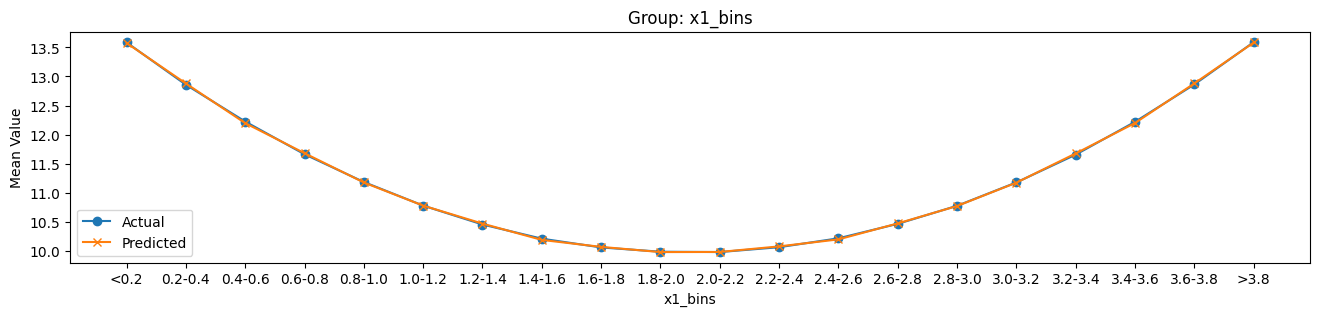

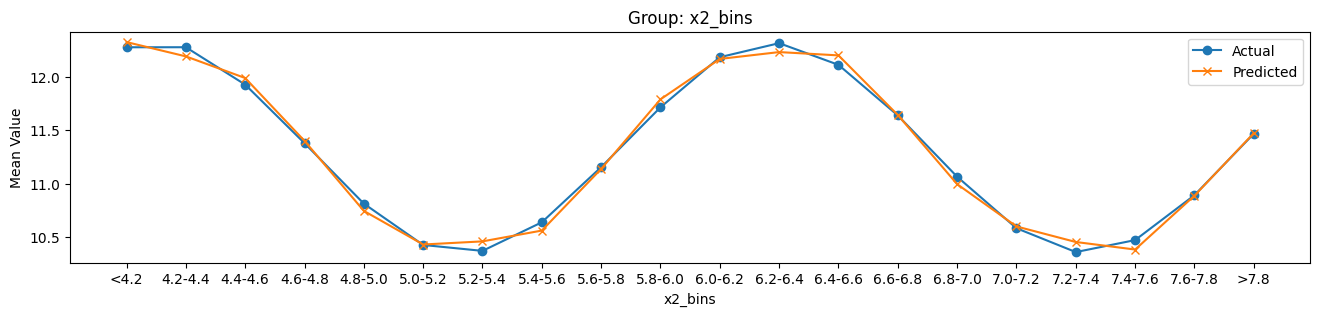

In [123]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example

In [130]:
probs = 1 / (1 + np.exp(-(df['y'] - 12)))
df['binary_y'] = np.random.binomial(1, probs)
df['binary_y'].mean()

0.381368

In [131]:
from quantbullet.optimizer import LinearProductClassifierScipy

lpc_scipy = LinearProductClassifierScipy(ftol=1e-6, gtol=1e-6, eps=1e-3)

In [132]:
lpc_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, init_params=np.ones(train_df.shape[1]) * 0.02, verbose=True )

Iter 1: 667392.1382493051
Iter 2: 665034.007215652
Iter 3: 657794.6191891048
Iter 4: 652721.1387484876
Iter 5: 643213.0789461749
Iter 6: 636567.404163341
Iter 7: 630809.2100304672
Iter 8: 622717.528519306
Iter 9: 606007.1413573022
Iter 10: 605839.5914298107
Iter 11: 605372.502761313
Iter 12: 605263.7534776473
Iter 13: 603800.0815230157
Iter 14: 603657.96158414
Iter 15: 603073.8961241352
Iter 16: 601007.4667202273
Iter 17: 594329.4232237086
Iter 18: 585747.5244635738
Iter 19: 584808.9002793957
Iter 20: 582070.3732803809
Iter 21: 580626.3479569264
Iter 22: 576540.4072599326
Iter 23: 575748.4711790025
Iter 24: 575599.7206091677
Iter 25: 572499.795304847
Iter 26: 569740.7214838922
Iter 27: 568010.3751739893
Iter 28: 566780.5420350824
Iter 29: 565856.1052861753
Iter 30: 564954.9423810849
Iter 31: 563782.4077893512
Iter 32: 563540.7214444029
Iter 33: 563305.2054466278
Iter 34: 563088.1452601501
Iter 35: 562529.0843766875
Iter 36: 562464.7906942596
Iter 37: 562385.3160361925
Iter 38: 562359.4

In [139]:
lpc_scipy.coef_

array([-1.38410911, -0.87512904, -1.08530496, -0.35764192,  0.01169358,
       -0.00925392,  0.35839204,  1.45580632, -0.40618695,  0.16279362,
       -0.02060666, -0.54031766, -0.00692794,  0.5031842 ,  0.14310393,
       -0.57427535, -0.15240994,  0.55955516])

In [140]:
df['clf_scipy_pred_prob'] = lpc_scipy.predict_proba(train_df)

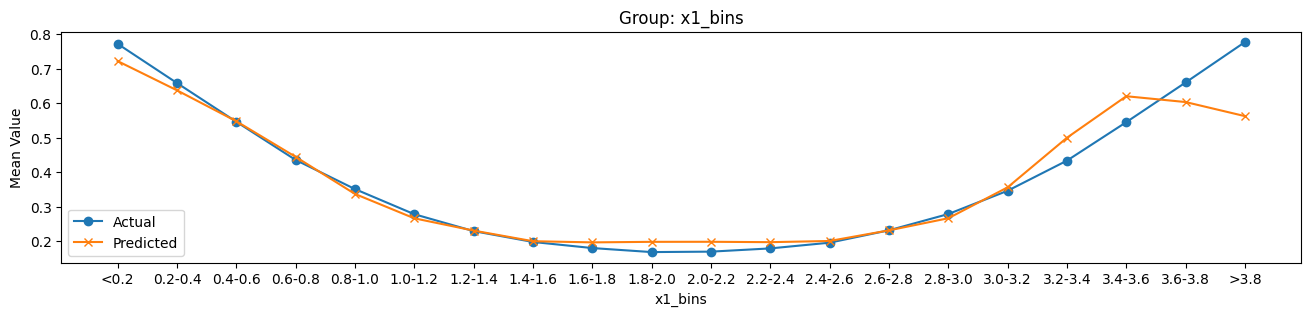

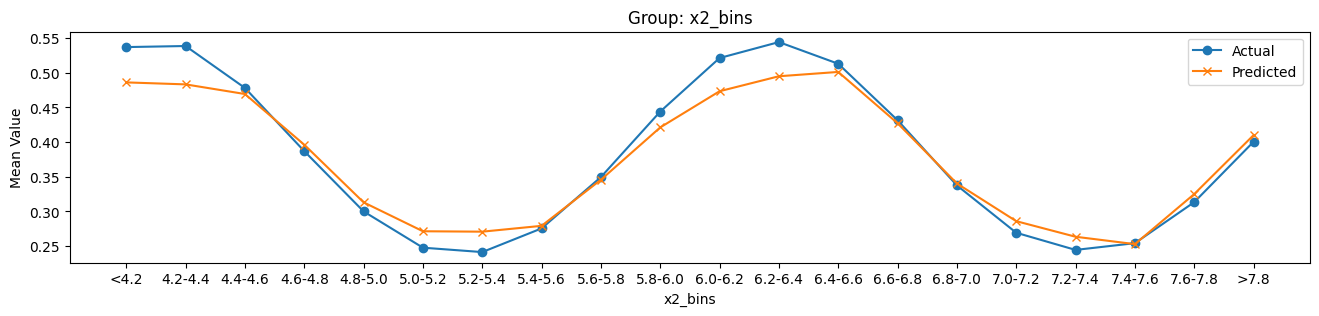

In [141]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'clf_scipy_pred_prob': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['clf_scipy_pred_prob'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

## Classification Example: Minimizing MSE, use OLS for Classification

In [10]:
probs = 1 / (1 + np.exp(-(df['y'] - 15)))
df['binary_y'] = np.random.binomial(1, probs)

In [15]:
from quantbullet.optimizer import LinearProductModelScipy, LinearProductModelOLS

lprm_ols = LinearProductModelOLS()

In [16]:
lprm_ols.fit( train_df, df['binary_y'], feature_groups=feature_groups, n_iterations=10 )

Iteration 1/10, MSE: 0.0826
Iteration 2/10, MSE: 0.5061
Iteration 3/10, MSE: 4.5408
Iteration 4/10, MSE: 32.7612
Iteration 5/10, MSE: 0.9933
Iteration 6/10, MSE: 0.2992
Iteration 7/10, MSE: 0.7024
Iteration 8/10, MSE: 0.3121
Iteration 9/10, MSE: 5.4975
Iteration 10/10, MSE: 11.9660


In [17]:
lprm_ols.coef_dict

{'x1': {'x1_bias': -2.3206663556926124,
  'x1_le_1': -1.4348630000122466,
  'x1_1_2': -0.1477757350329853,
  'x1_2_3': 0.14744827538046906,
  'x1_gt_3': 1.429279958995111},
 'x2': {'x2_bias': -47.76730903986184,
  'x2_le_5': 0.1504082375972737,
  'x2_5_6': 0.3104809326789891,
  'x2_6_7': -0.37154690856014316,
  'x2_gt_7': 6.829308712521195}}

In [18]:
df['model_predict_BCD'] = lprm_ols.predict(train_df)

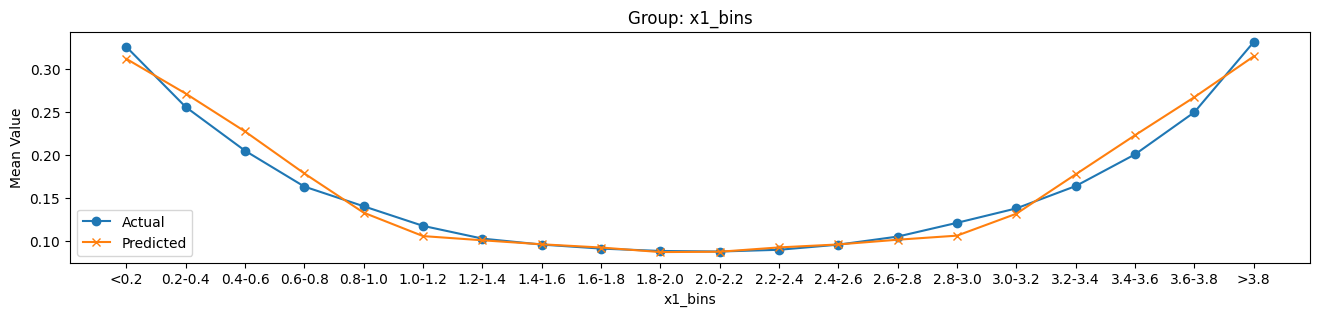

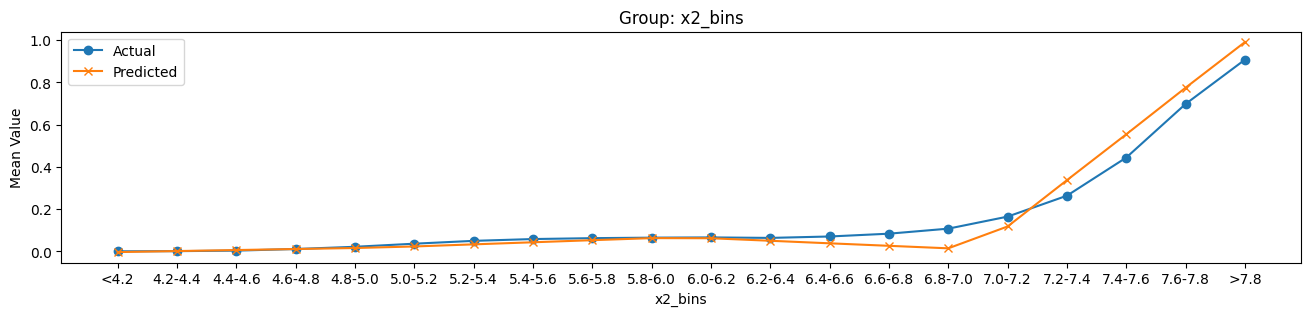

In [19]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict_BCD': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict_BCD'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()

In [20]:
# import the mse function
from sklearn.metrics import mean_squared_error
mse_bcd = mean_squared_error(df['binary_y'], df['model_predict_BCD'])
print(f'MSE (Alternating Coordinate Descent + OLS): {mse_bcd:.4f}')
mse_scipy = mean_squared_error(df['binary_y'], df['model_predict'])
print(f'MSE (Scipy Optimization): {mse_scipy:.4f}')

MSE (Alternating Coordinate Descent + OLS): 0.0826
MSE (Scipy Optimization): 134.3408


In [21]:
lpm_scipy = LinearProductModelScipy( xtol=1e-12, ftol=1e-12, gtol=1e-12 )
lpm_scipy.fit( train_df, df['binary_y'], feature_groups=feature_groups, verbose=2, use_jacobian=False)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.5750e+10                                    1.77e+10    
       1              2         6.1303e+09      1.96e+10       3.16e+00       1.18e+10    
       2              4         9.5544e+07      6.03e+09       1.58e+00       1.25e+09    
       3              5         2.7311e+06      9.28e+07       3.16e+00       4.20e+07    
       4              8         1.6227e+05      2.57e+06       3.95e-01       1.55e+06    
       5             10         8.4729e+04      7.75e+04       1.98e-01       7.21e+05    
       6             12         5.1849e+04      3.29e+04       4.94e-02       7.76e+04    
       7             13         5.1575e+04      2.73e+02       9.88e-02       4.36e+05    
       8             14         4.6847e+04      4.73e+03       2.47e-02       9.33e+03    
       9             15         4.6139e+04      7.07e+02       4.94e-02       1.29e+04    

In [23]:
df['model_predict'] = lpm_scipy.predict(train_df)

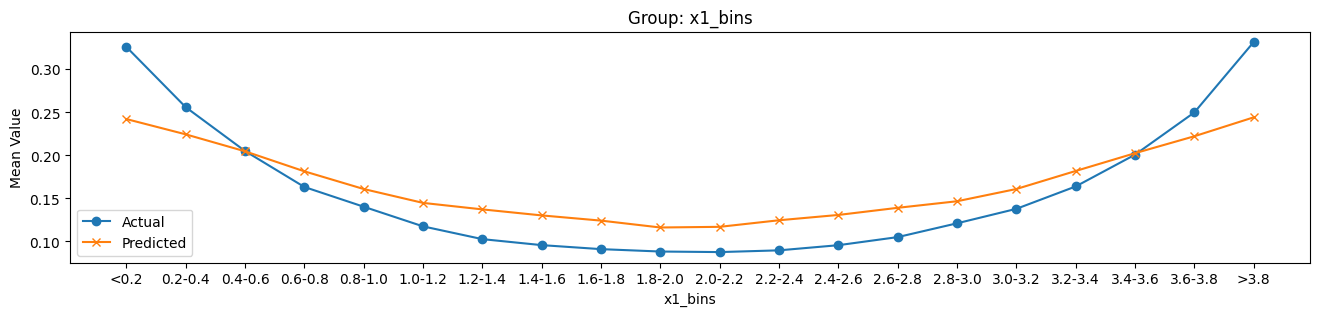

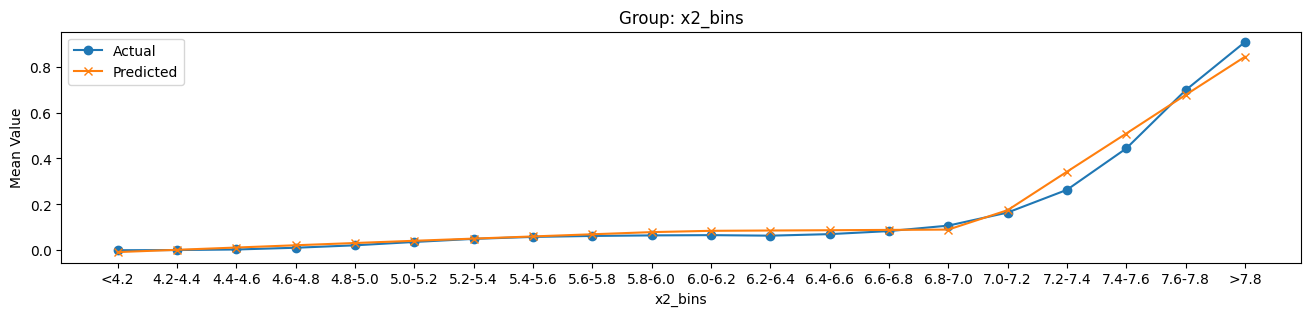

In [24]:
for group in ['x1_bins', 'x2_bins']:
    plt.figure(figsize=(16, 3))
    summary = df.groupby(group, observed=True).agg({'binary_y': 'mean', 'model_predict': 'mean'})
    plt.plot(summary.index, summary['binary_y'], label='Actual', marker='o')
    plt.plot(summary.index, summary['model_predict'], label='Predicted', marker='x')
    plt.title(f'Group: {group}')
    plt.xlabel(group)
    plt.ylabel('Mean Value')
    plt.legend()